In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


## Generate Data
df = pandas.read_csv('hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float)
yobs = np.array([hare,lynx]).T 
yobs_norm = yobs / yobs.std(axis=0)


## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 + p.pn[10] - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 + p.pn[11] - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}


d = 12

model_sunode = pm.Model()

with model_sunode:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    xi = pm.Bernoulli('xi', 0.8, shape=d)
    pnss = pm.Deterministic('pnss', pn * xi)
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pnss,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

with model_sunode:

    start = pm.find_MAP()

    # Initialize parameters with least squares and all other values with MAP
    inp = yobs_norm
    u = inp[:,0]
    v = inp[:,1]

    θ = np.array([u,v,u*v,u**2,v**2,np.ones(u.shape)]).T

    import pysindy as ps
    from pysindy.differentiation import SmoothedFiniteDifference
    sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    dx = sfd(inp)

    guess = np.linalg.lstsq(θ,dx)[0]
    
    print('Initialization')
    print(guess)

    start['pn'] = guess.flatten()
    start['pnss'] = start['pn']
    start['xi'] = np.ones(start['pn'].shape).astype(int)
    start['y0'] = yobs_norm[0,:]
    start['y0_log__'] = np.log(start['y0'])

    #trace = pm.sample(4000, tune=1000, cores=2, start=start,random_seed=0,step_kwargs={'nuts':{'target_accept':0.95}})
    trace = pm.backends.load_trace('real_ss_12param' + '.trace',model_sunode)




logp = -91, ||grad|| = 505.17: 100%|██████████| 8/8 [00:00<00:00, 130.39it/s]
/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Initialization
[[ 0.67745872 -0.08466578]
 [-0.09671527 -1.14033485]
 [-0.16558271  0.15817824]
 [-0.09951633  0.11087658]
 [-0.04709275  0.23517823]
 [-0.17829224  0.20845188]]


In [5]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
pn[0],0.335,0.583,-0.861,1.050,0.045,0.049,166.0,70.0,60.0,58.0,1.13
pn[1],-0.079,1.091,-2.206,2.051,0.062,0.044,307.0,307.0,214.0,1250.0,1.03
pn[2],0.040,0.865,-1.780,1.596,0.067,0.048,166.0,166.0,47.0,727.0,1.09
pn[3],-0.766,0.263,-1.139,0.001,0.054,0.038,24.0,24.0,32.0,22.0,1.07
pn[4],-0.539,0.386,-1.166,-0.093,0.030,0.028,162.0,94.0,19.0,67.0,1.09
pn[5],0.487,0.143,0.260,0.836,0.034,0.024,18.0,18.0,17.0,91.0,1.09
pn[6],-0.042,0.915,-2.824,1.103,0.136,0.097,45.0,45.0,51.0,39.0,1.16
pn[7],0.112,1.274,-2.241,2.373,0.074,0.052,298.0,298.0,219.0,1438.0,1.02
pn[8],-0.058,1.102,-2.320,2.185,0.030,0.027,1365.0,850.0,595.0,1148.0,1.03
pn[9],0.030,1.102,-2.252,2.426,0.069,0.062,253.0,157.0,317.0,187.0,1.01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ff8a7ccd0>,
      dtype=object)

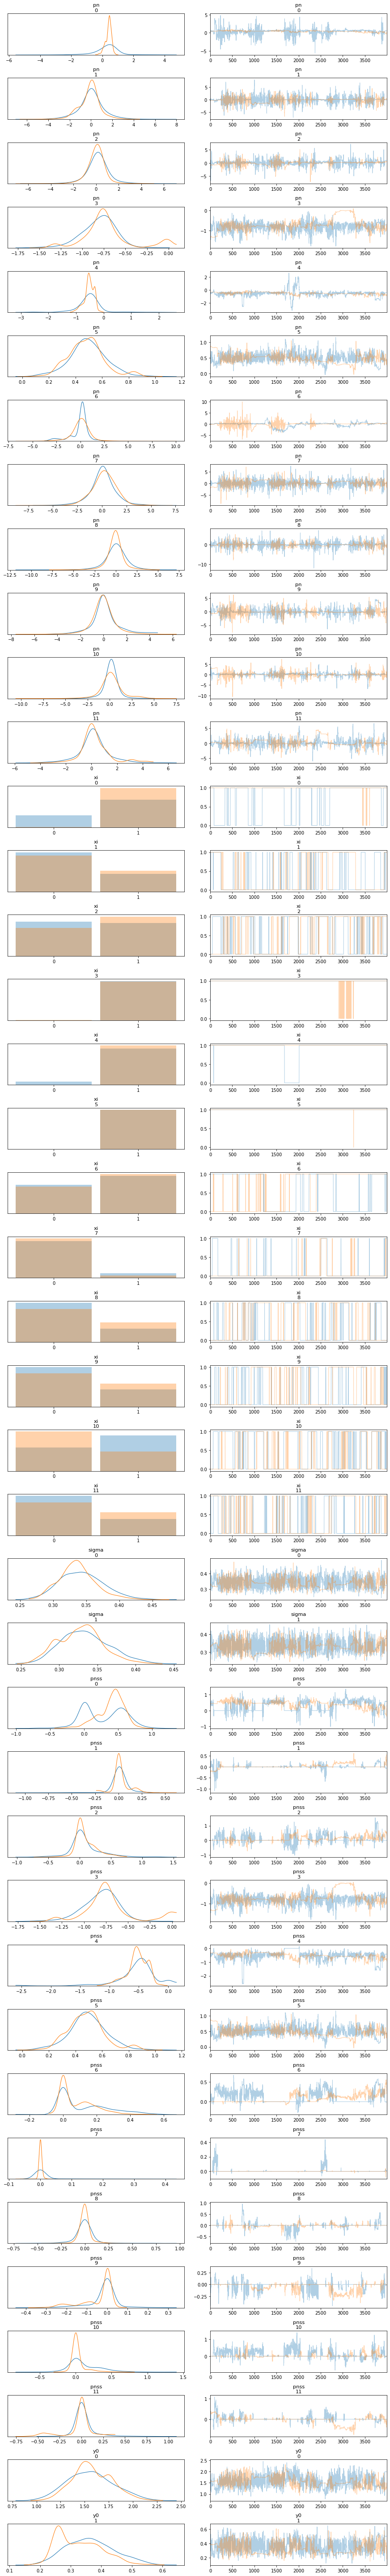

In [7]:
pm.plot_trace(trace)

<bound method Axes.plot of <matplotlib.axes._subplots.AxesSubplot object at 0x7f9fe0541590>>

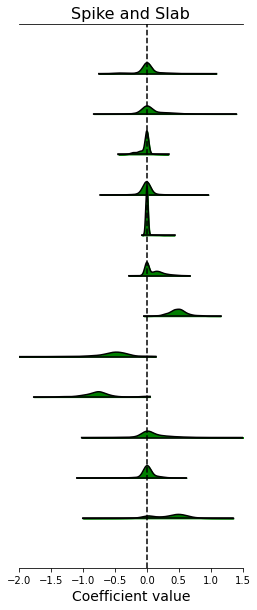

In [8]:
plt.figure(figsize=(4,10))
ax = plt.subplot(1,1,1)
ax.plot([0, 0], [-0.05, 0.5], 'k--')
pm.forestplot((trace['pnss']).T, credible_interval=0.95, kind='ridgeplot', colors='green', ridgeplot_overlap=0.05, ax=ax)
#ax.set_title('')
#ax.set_xlabel('Coefficient value')
#ax.set_ylabel('Coefficient')
ax.set_xlim(-2, 1.5)
ax.set_ylim(-0.05, 0.5)
#ax.set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85)
#ax.set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'], fontsize=16)

ax.set_xlabel('Coefficient value', fontsize=14)
plt.title('Spike and Slab', fontsize=16)
plt.yticks([])    
ax.plot